In [367]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import opinf

from scipy.io import loadmat

In [368]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [369]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data
dt = 1e-3
T_end = 2
X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :int(T_end/dt+1), :]

In [370]:
X_all.shape

(5, 2001, 130)

In [371]:
p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQPC",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 0.0,
        "lambda2": 1.0,
        "lambda3": 4.0,
    },
    "type": "single"
}




In [372]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [373]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


In [374]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

In [391]:
# Model parameters
# r = 30
q = 40
p = 2

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

X = X_all.reshape(-1, X_all.shape[2]).T
# IC = np.array([initial_condition(coord) for coord in np.linspace(0, 1, X.shape[0])])[:, None]
# X_ref = np.mean(X, axis=1)[:, None]
X_ref = np.zeros((X.shape[0], 1))
X = X - X_ref

# st = opinf.pre.SnapshotTransformer(center=True, scaling="standard", verbose=True)
# X = st.fit_transform(X)

basis = opinf.basis.PODBasis().fit(X, residual_energy=1e-3)
# basis = opinf.basis.PODBasis().fit(X, r=19)
print(basis.shape)

(130, 32)


In [376]:
# Instantiate the model.
rom = opinf.models.ContinuousModel(operators=[
    opinf.operators.ConstantOperator(),
    opinf.operators.LinearOperator(),
    opinf.operators.QuadraticOperator(),
])

In [397]:
# Compress the snapshot data.
Q_compressed = basis.compress(X)

# Estimate time derivatives (dq/dt) for each training snapshot.

Mp = len(mus)
Nsnapshots = X.shape[1]
Qdot_train_lst = []
Q_train_lst = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    Qdot_train, ind = ddt(Q_compressed[:, start_ind:end_ind], dt=dt, scheme="BE")
    # ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="2imp")
    Qdot_train_lst.append(Qdot_train)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Q_train_lst.append(Q_compressed[:, ind])
    
# Qdot_train = (Q_compressed[:, 1:] - Q_compressed[:, :-1]) / dt
# Q_train = Q_compressed[:, 1:]  # Training snapshots.

Qdot_train = np.concatenate(Qdot_train_lst, axis=1)
Q_train = np.concatenate(Q_train_lst, axis=1)

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005
shape of Q_train:	(32, 10000)
shape of Qdot_train:	(32, 10000)


In [378]:
# Train the reduced-order model.
r = basis.shape[1]
tikhonov_regularizer = np.diag([1.00] * (1 + r + r * (r + 1) // 2))  # Tikhonov regularization matrix.
tikhonov_regularizer[:r+1, :] *= 1 # regularize the constant term and linear term less
tikhonov_regularizer[r+1:, :] *= 1 # regularize the quadratic term more
print(tikhonov_regularizer.shape)
solver = opinf.lstsq.TikhonovSolver(regularizer=tikhonov_regularizer)          # Select a least-squares solver with regularization.
# solver = opinf.lstsq.L2Solver(5e-2)          # Select a least-squares solver with regularization.
rom.fit(states=Q_train, ddts=Qdot_train, solver=solver)  # Fit the model to the training data.
# rom.fit(states=Q_train, ddts=Qdot_train)
print(rom)

(561, 561)
Model structure: dq / dt = c + Aq(t) + H[q(t) ⊗ q(t)]
State dimension r = 32


In [379]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# coordinates are equally spaced points from 0 to 1 with 2^7 + 1 points
N = 2**7 + 1 + 1
coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])

# Express the initial condition in the coordinates of the basis.
q0_ = basis.compress(IC)

coord =  (130,)


In [380]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


In [413]:
# Solve the reduced-order model using Implicit Euler.
num_snapshots = X.shape[1]
# Solve the model.
T_end_full = 8
time_domain = np.arange(0, T_end_full, dt)
result = rom.predict(q0_, time_domain)

In [382]:
s_rec = basis.decompress(result)
# s_rec = s_rec + IC[:, None]
# s_rec = st.inverse_transform(s_rec)

In [383]:
X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")

X =  (130, 8000)
Y =  (130, 8000)
s_ref_all[i] =  (2001, 130)


/tmp/ipykernel_2312766/397870264.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


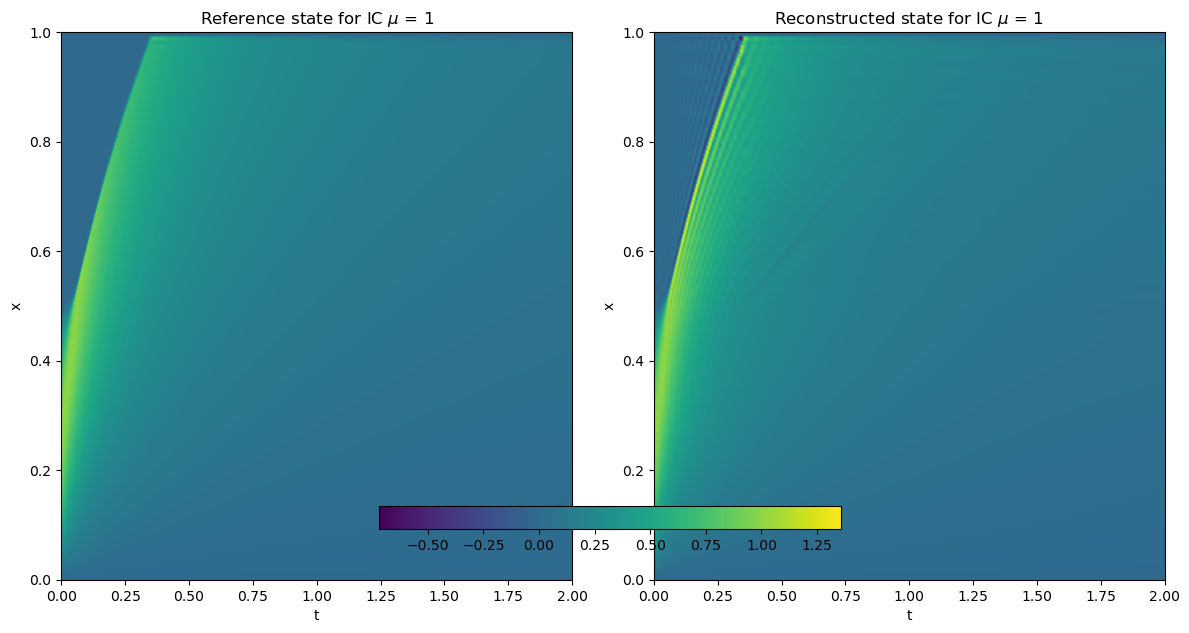

In [384]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end, int(X_all_full[2].shape[0])), np.linspace(0.0, 1.0, X_all[2].shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", X_all[2].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(X_all_full[2].T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for IC $\mu$ = {mus[2]}')
    
    c2 = axs[1].imshow(s_rec, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Reconstructed state for IC $\mu$ = {mus[2]}')  
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(X_all_full[2]), np.min(s_rec)])
    vmax = np.max([np.max(X_all_full[2]), np.max(s_rec)])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()

In [385]:
# relative error
rel_error = np.linalg.norm(X_all_full[2].T[:, T_end:] - s_rec[:, T_end:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end:], 'fro')
print(f"Relative error: {rel_error:.2e}")

Relative error: 1.27e-01
